In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn jupyter

     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     --------------------------------------- 0.0/11.3 MB 325.1 kB/s eta 0:00:35
     --------------------------------------- 0.1/11.3 MB 409.6 kB/s eta 0:00:28
     --------------------------------------- 0.1/11.3 MB 391.3 kB/s eta 0:00:29
     --------------------------------------- 0.1/11.3 MB 391.3 kB/s eta 0:00:29
     --------------------------------------- 0.1/11.3 MB 423.5 kB/s eta 0:00:27
     --------------------------------------- 0.1/11.3 MB 425.3 kB/s eta 0:00:27
     --------------------------------------- 0.1/11.3 MB 425.3 kB/s eta 0:00:27
     --------------------------------------- 0.1/11.3 MB 425.3 kB/s eta 0:00:27
      -------------------------------------- 0.2/11.3 MB 349.3 kB/s eta 0:00:32
      -------------------------------------- 0.2/11.3 MB 337.4 kB/s eta 0:00:34
      -------------------------------------- 0.2/11.3 MB


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
# Load the dataset
CSV_PATH = 'apartments_for_rent_classified_10K.csv'
df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="cp1252")

df.columns = (
    df.columns                # Get the current column names
      .str.strip()            # Remove leading/trailing spaces
      .str.lower()            # Convert all letters to lowercase
      .str.replace(r"\s+", "_", regex=True)  # Replace spaces/tabs with underscores
)

# Drop columns that are not needed for prediction
cols_to_drop = ['price_display']
df = df.drop(columns=cols_to_drop)

# Display first few rows
df.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,1390,Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


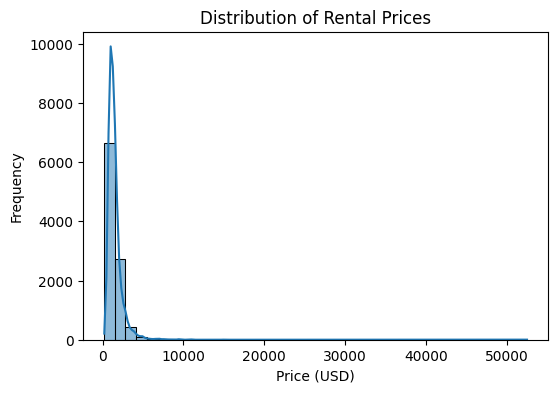

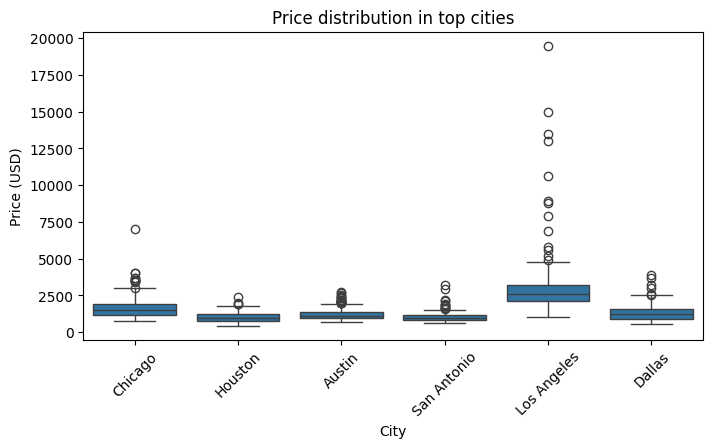

In [9]:
# Visualise the distribution of the target variable
plt.figure(figsize=(6,4))
sns.histplot(df['price'], bins=40, kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

# If city names are available, show price distribution across the most common cities
if 'cityname' in df.columns:
    top_cities = df['cityname'].value_counts().head(6).index
    plt.figure(figsize=(8,4))
    sns.boxplot(x='cityname', y='price', data=df[df['cityname'].isin(top_cities)])
    plt.title('Price distribution in top cities')
    plt.xlabel('City')
    plt.ylabel('Price (USD)')
    plt.xticks(rotation=45)
    plt.show()

In [10]:
# Custom transformer to add a few engineered features
class AddCustomFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_features=True):
        self.add_features = add_features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        if not self.add_features:
            return X
        # Bedrooms-to-bathrooms ratio
        if {'bedrooms','bathrooms'}.issubset(X.columns):
            denom = X['bathrooms'].replace(0, np.nan) + 1e-6
            X['bed_bath_ratio'] = X['bedrooms'] / denom
        # Count of amenities if column exists
        if 'amenities' in X.columns:
            X['amenity_count'] = X['amenities'].fillna('').astype(str).str.count(',') + X['amenities'].notna().astype(int)
        # Length of title and body text
        if 'title' in X.columns:
            X['title_len'] = X['title'].fillna('').astype(str).str.len()
        if 'body' in X.columns:
            X['body_len'] = X['body'].fillna('').astype(str).str.len()
        # Log transform of square_feet to reduce skew
        if 'square_feet' in X.columns:
            X['log_square_feet'] = np.log1p(pd.to_numeric(X['square_feet'], errors='coerce'))
        return X

# Preprocessor that dynamically separates numeric and categorical columns
class DynamicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.preprocessor_ = None
    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = [c for c in X.columns if c not in numeric_cols]
        num_tf = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        cat_tf = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
        self.preprocessor_ = ColumnTransformer([
            ('num', num_tf, numeric_cols),
            ('cat', cat_tf, categorical_cols)
        ])
        self.preprocessor_.fit(X, y)
        return self
    def transform(self, X):
        return self.preprocessor_.transform(X)


In [11]:
# For simplicity, drop a few identifier columns that have no predictive power
cols_to_drop = ['id','source']
drop_cols_exist = [c for c in cols_to_drop if c in df.columns]
use_cols = [c for c in df.columns if c not in drop_cols_exist]

X = df[use_cols].copy()
y = df['price'].copy()

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)


Training set size: (8000, 19)
Test set size: (2000, 19)


In [12]:
# Create a pipeline with the custom feature engineer, preprocessor and decision tree
pipe_dt = Pipeline([
    ('features', AddCustomFeatures()),
    ('prep', DynamicPreprocessor()),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Define a search space for the decision tree
search_space_dt = {
    'features__add_features': [True, False],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 2, 5],
    'model__min_samples_split': [2, 5, 10]
}

# Perform randomized search with a limited number of iterations
rs_dt = RandomizedSearchCV(
    pipe_dt,
    param_distributions=search_space_dt,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)

# Fit the search to the training data
rs_dt.fit(X_train, y_train)

print('Best parameters:', rs_dt.best_params_)
print('Best CV RMSE:', -rs_dt.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 20, 'features__add_features': False}
Best CV RMSE: 407.8155712152091


Decision Tree performance on test set:
MAE:  4.23
RMSE: 89.71
R^2:  0.9910


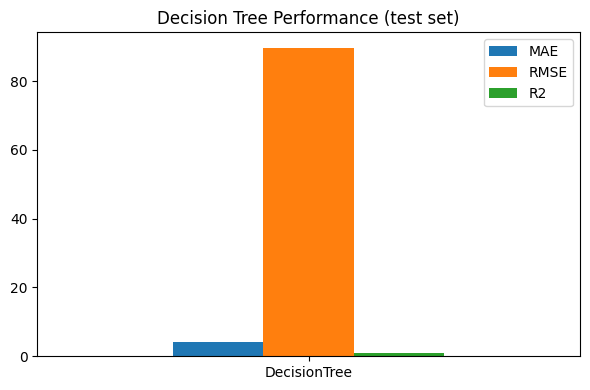

In [13]:
# Retrieve the best estimator and make predictions on the test set
best_dt = rs_dt.best_estimator_
pred = best_dt.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print('Decision Tree performance on test set:')
print(f'MAE:  {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R^2:  {r2:.4f}')

# Put results in a DataFrame for nice display
results = pd.DataFrame({
    'MAE': [mae],
    'RMSE': [rmse],
    'R2': [r2]
}, index=['DecisionTree'])

import matplotlib.pyplot as plt
results.plot(kind='bar', figsize=(6,4))
plt.title('Decision Tree Performance (test set)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
